In [2]:
import numpy as np
from statistics import mode
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

In [3]:
def retList(filename):
    f = open(filename,'r')
    dataString = f.readlines()
    data = []
    for i in range(len(dataString)):
        data.append(dataString[i].split())
    return np.array(data,dtype=float)

def accuracy(label, predicted):
    N= len(predicted)
    crt = 0
    for i in range(N):
        if label[i] == predicted[i]:
            crt=crt+1
    if N==0:
        raise ValueError("Input array size must be greater than 0")
    return crt/N

def randomList(n, bool, m=None):
    if m is None:
        m = int(np.sqrt(n)) 
    if bool:
        return np.random.choice(n-1,m)
    else :
        return np.array(range(n-1))

In [4]:
def giniIndex(data):
    pos, neg = 0,0
    for i in data:
        if i[-1]==0:
            neg=neg+1
        else :
            pos=pos+1
    
    pos=pos/(pos+neg)
    neg=1-pos
    return 1-pos*pos-neg*neg

def entropy(data): 
    if len(data)==0:
        return 0   
    n0,n1=0,0
    for i in data:
        if i[-1]==0:
            n0=n0+1
        else:
            n1=n1+1
    p1=n0/(n1+n0)
    p2=1-p1
    if p1 != 0:
        p1=-p1*np.log(p1)
    if p2 != 0:
        p2=-p2*np.log(p2)
    return p1+p2



In [5]:
def BestSplit(data, numThreshold, func, featureList):
    InfoGain = 0
    Left=None
    Right=None
    Threshold=None
    Feature=None
    for feature in featureList:
        minVal = np.min(data[:,feature])
        maxVal = np.max(data[:,feature])
        Tvals = np.linspace(minVal,maxVal,numThreshold+1,endpoint=False)[1:]

        for threshold in Tvals:
            left=[]
            right=[]
            for instance in data:
                if instance[feature]<threshold:
                    left.append(instance)
                else :
                    right.append(instance)
            if len(left)==len(data) or len(right)==len(data):
                continue
            infogain = func(data)-len(left)/len(data)*func(left)-len(right)/len(data)*func(right)
            if infogain > InfoGain:
                Threshold = threshold
                Feature = feature
                InfoGain = infogain
                Left= np.array(left)
                Right = np.array(right)
    # if len(Left)==len(data) or len(Right)==len(data):
    #     Left=None
    #     Feature=None
    #     Threshold=None
    #     Right = None
    return {'feature':Feature, 'threshold': Threshold, 'left':Left, 'right':Right}




In [6]:
class DecisionTree():
    tree={}

    def learn(self, train, numThreshold, func, randomFeatures,m):
        tree = {'feature':None, 'threshold':None, 'leftTree':None,'rightTree':None, 'value':None}

        if func(train)!=0:
            split=BestSplit(train,numThreshold,func,randomList(len(train[0]),randomFeatures,m))
            tree['feature']=split['feature']
            tree['threshold']=split['threshold']
            if tree['feature'] is None:
                tree['value'] = mode(train[:,-1])
                return tree
            else:
                tree['leftTree'] = DecisionTree.learn(self,split['left'],numThreshold,func,randomFeatures,m)
                tree['rightTree'] = DecisionTree.learn(self,split['right'],numThreshold,func,randomFeatures,m)
                return tree
        else :
            tree['value']=mode(train[:,-1])
            return tree
    
    def classify(self,tree,instance):
        if tree['value'] is not None:
            return tree['value']
        else:
            if instance[tree['feature']] < tree['threshold']:
                return self.classify(tree['leftTree'],instance)
            else :
                return self.classify(tree['rightTree'],instance)
    
def runDecisionTree(train, test, numThreshold=10, func=entropy, randomFeatures=False,m=None):
    Tree=DecisionTree()
    tree= Tree.learn(train,numThreshold,func,randomFeatures)
    predicted = []
    for instance in test:
        predicted.append(Tree.classify(tree,instance[:-1]))
    print(accuracy(test[:,-1],predicted))


In [7]:
class randomForest():
    forest=[]
    def build(self, numTrees,train,numThreshold, func,m):
        forest=[]
        oob_data=[]
        for i in range(numTrees):
            np.random.shuffle(train)
            tree = DecisionTree().learn(train[:len(train)//10],numThreshold,func,True,m)  
            forest.append(tree)
            oob_data.append(train[len(train)//10:])
        return forest, oob_data

    def classify(self, forest, instance):
        predicted=[]
        for tree in forest:
            predicted.append(DecisionTree().classify(tree,instance))
        return mode(predicted)
    
def runRandomForest(numTrees, train, test,m=None, numThreshold=10, func=entropy,oob=False):
    Forest = randomForest()
    forest,oob_data = Forest.build(numTrees, train,numThreshold,func,m)
    oob_error=None
    predicted = []
    for instance in test:
        predicted.append(Forest.classify(forest,instance[:-1]))
    if oob:
        acc = 0
        for instance in train:
            pred = []
            for i in range(len(oob_data)):
                if np.any(np.all(np.isin(oob_data[i],instance,True),axis=1)):
                    Tree = DecisionTree()
                    pred.append(Tree.classify(forest[i],instance))
            if instance[-1]==mode(pred):
                acc=acc+1


        acc = acc/len(train)
        oob_error=1-acc
    return accuracy(test[:,-1],predicted),oob_error

    



In [12]:
data = retList("data.txt")
train = np.array([x for i, x in enumerate(data) if i % 10 > 2 ])
test = np.array([x for i, x in enumerate(data) if i % 10 <= 2])
np.random.shuffle(train)
print("The accuracy of random forest is:",runRandomForest(100,train,test,m=10,numThreshold=15,func=entropy)[0])
clf = RandomForestClassifier()
clf.fit(train[:,:-1],train[:,-1])
predicted = clf.predict(test[:,:-1])
print("The accuracy of sklearn random forest is:",accuracy(test[:,-1],predicted))



The accuracy of random forest is: 0.9514844315713251
The accuracy of sklearn random forest is: 0.9608979000724113


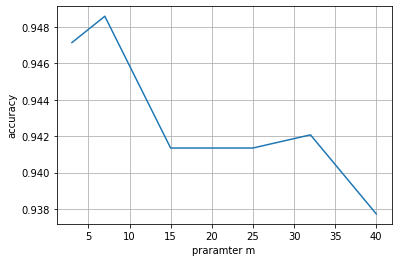

In [14]:
x,y=[],[]
for m in [3,7,15,25,32,40]:
    y.append(runRandomForest(100,train,test,m))
    x.append(m)
plt.plot(x,y)
plt.grid()
plt.xlabel("praramter m")
plt.ylabel('accuracy')
plt.show()



In [15]:
print("The oob error is :",runRandomForest(100,train,test,oob=True)[1])

The oob error is : 0.05124223602484468


In [48]:
for m in [7,14,21,35]:
    print("m:",m)
    print("The oob error is :",runRandomForest(10,train,test,oob=True,m=m)[1])

m: 7
The oob error is : 0.0670807453416149
m: 14
The oob error is : 0.0661490683229814
m: 21
The oob error is : 0.07329192546583851
m: 35
The oob error is : 0.07391304347826089
